<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#Prepare-adjacent-matrix" data-toc-modified-id="Prepare-adjacent-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare adjacent matrix</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Implementation</a></span></li></ul></div>

# NumPy implementation of Spatiotemporal Laplacian-enhanced low-rank tensor kriging model

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Tong Nie, Guoyang Qin, Yunpeng Wang, and Jian Sun (2023). <b>Correlating sparse sensing for large-scale traffic speed estimation: A Laplacian-enhanced low-rank tensor kriging approach</b>. Transportation Research Part C: Emerging Technologies, 152, 104190 <a href="https://doi.org/10.1016/j.trc.2023.104190" title="DOI"><b>[DOI]</b></a> <a href="https://github.com/tongnie/tensor4kriging" title="Github"><b>[Github]</b></a> 
</font>
</div>

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import random
import scipy as scipy
import utils as ut
import time
import pickle
import pymetis
plt.rcParams['font.family']='arial'
plt.rcParams['svg.fonttype']='none'

IPython.display.set_matplotlib_formats('svg')
%matplotlib inline

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17256\180850073.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats('svg')


## load data

In [2]:
data = pd.read_csv('California-data-set/pems-4w.csv', header = None)
speed_mat = data.values.T
print(speed_mat.shape)

(8064, 11160)


## Prepare adjacent matrix

In [3]:
def load_graph_data(pkl_filename):
    sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(pkl_filename)
    return sensor_ids, sensor_id_to_ind, adj_mx

def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data


sid, sind, adj = load_graph_data('California-data-set/adj_mat.pkl')
print(adj.shape)

(11160, 11160)


In [4]:
def TensorFromMat(mat,dim):
    #Construct a (time interval * location * day) tensor from a (time * location) matrix
    days_slice = [(start_i,start_i + dim[0]) for start_i in list(range(0,dim[0]*dim[2],dim[0]))]
    array_list = []
    for day_slice in days_slice:
        start_i,end_i = day_slice[0],day_slice[1]
        array_slice = mat[start_i:end_i,:]
        array_list.append(array_slice)
        tensor3d = np.array(np.stack(array_list,axis = 0))
        tensor3d = np.moveaxis(tensor3d,0,-1)

    return tensor3d

    
def Tensor2Mat(tensor):
    #convert a tensor into a matrix by flattening the 'day' mode to 'time interval'.
    for k in range(np.shape(tensor)[-1]):
        if k == 0:
            stacked = np.vstack(tensor[:,:,k])
        else:
            stacked = np.vstack((stacked,tensor[:,:,k]))
            
    return stacked

## Model

In [5]:
# construct symmetric Laplacian
def construct_Laplacian(adj):
    degree = np.diag(np.sum(adj,axis=1))
    temp = degree-adj
    if np.allclose(temp,temp.transpose()):
        Lap = temp.copy()
    else:
        print('Error Construction')
        Lap = None
        
    return Lap

import scipy.linalg
def temporal_regularizer(T, tau):
    "shape: (T-tau)*T"
    ell = np.zeros(T)
    ell[0] = tau
    for k in range(tau):
        ell[k + 1] = -1
    return scipy.linalg.circulant(ell)[tau:,:]

def periodic_graph(days):
    A_p = np.diag([1 for i in range(days)])
    A_p += np.diag([1 for i in range(days-1)],1)
    if days > 7:
        for t in range(days//7):
            wk = (t+1)*7
            A_p += np.diag([1 for i in range(days-wk)],wk).astype('int32')
    A_p = np.maximum.reduce([A_p,A_p.T])
    
    return A_p

def cal_graph_operator(L):
    eigenvalues,eigenvectors = np.linalg.eigh(L)
    inds = np.argsort(eigenvalues)
    U = eigenvectors[:,inds]
    
    return U

# graph Fourier transform
def GFT(tensor, U):
    return np.einsum('kt, ijk -> ijt', U, tensor)  #mode-3 product

def iGFT(tensor, U):
    return np.einsum('kt, ijt -> ijk', U, tensor)  #mode-3 product(transpose)

def power_iteration(AA, Omega, power_iter = 1):
    Y = AA @ Omega
    for q in range(power_iter):
        Y = AA @ (AA.T @ Y)
    Q, _ = np.linalg.qr(Y)
    return Q

# randomized SVD
def rsvd(mat, Omega):
    A = mat.copy()
    Q = power_iteration(A, Omega)
    B = Q.T @ A
    u_tilde, s, v = np.linalg.svd(B, full_matrices = 0)
    u = Q @ u_tilde
    return u, s, v

#conjugate gradient
def update_cg(var, r, q, Aq, rold):
    alpha = rold / np.inner(q, Aq)
    var = var + alpha * q
    r = r - alpha * Aq
    rnew = np.inner(r, r)
    q = r + (rnew / rold) * q
    return var, r, q, rnew

def ell_z(Z,Lc2,Lr2,rc,rr,mu):
    ell_z = rc*Z@Lc2 + rr*Lr2@Z +mu*Z
    return ell_z

# update z variable
def conj_grad_Z(C,Z,Lc2,Lr2,rc,rr,mu,maxiter = 3):
    dim1, dim2 = Z.shape
    z = np.reshape(Z, -1, order = 'F')
    r = np.reshape(C - ell_z(Z,Lc2,Lr2,rc,rr,mu), -1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (dim1, dim2), order = 'F')
        Aq = np.reshape(ell_z(Q,Lc2,Lr2,rc,rr,mu), -1, order = 'F')
        z, r, q, rold = update_cg(z, r, q, Aq, rold)
        
    return np.reshape(z, (dim1, dim2), order = 'F')

# update x variable
def tsvt_gft(tensor, Ug, ta,Omg,is_rsvd):
    dim = tensor.shape
    X = np.zeros(dim)
    tensor = GFT(tensor, Ug)
    for t in range(dim[2]):
        if is_rsvd==True:
            u, s, v = rsvd(tensor[:, :, t].T, Omg)
            r = len(np.where(s > ta)[0])
            if r >= 1:
                s = s[: r]
                s[: r] = s[: r] - ta
                X[:, :, t] = (u[:, :r] @ np.diag(s) @ v[:r, :]).T
        else:
            u, s, v = np.linalg.svd(tensor[:, :, t], full_matrices = False)
            r = len(np.where(s > ta)[0])
            if r >= 1:
                s = s[: r]
                s[: r] = s[: r] - ta
                X[:, :, t] = u[:, : r] @ np.diag(s) @ v[: r, :]
    return iGFT(X, Ug)

def solver(complete_tensor,missing_tensor,Lc2,Lr2,rc,rr,beta,transform,is_rsvd,incre,maxIter,epsilon):
    errList,MAE_List,RMSE_List,MAPE_List  = [],[],[],[]
    dim = missing_tensor.shape
    missing_mat = Tensor2Mat(missing_tensor)
    pos_missing = np.where(missing_mat == 0)
    X = np.zeros(dim) 
    Q = np.zeros(dim) 
    Z = missing_mat.copy()                     
    Z[pos_missing] = np.mean(missing_mat[missing_mat != 0])  #Initialize with mean values
    last_tensor = missing_tensor.copy()
    Z_tensor = TensorFromMat(Z,dim)
    At = periodic_graph(Z_tensor.shape[2])
    Lap_t = construct_Laplacian(At)    
    del At
    Ug = cal_graph_operator(Lap_t)
    print('ADMM Iteration:     ')  
    
    kk=5
    np.random.seed(100)
    for k in range(maxIter):
        beta = beta * (1+incre) #Increase beta with given step
        print(f'\r Processing loop {k}',end = '',flush=True)
        
        #Update X variable
        Omega = np.random.randn(Z_tensor[:, :, 0].shape[0], int(1.1*kk))
        X = tsvt_gft(Z_tensor - Q / beta, Ug, 1 / beta,Omega,is_rsvd)
        
        #Updata Z variable 
        C = Tensor2Mat(beta*X + Q)
        temp_mat = conj_grad_Z(C,Z,Lc2,Lr2,rc,rr,beta)
        Z[pos_missing] = temp_mat[pos_missing].copy() #Observed data
        Z_tensor = TensorFromMat(Z,dim)
        
        #Update Q variable
        Q = Q + beta*(X-Z_tensor)
        
        errList_k = np.linalg.norm(X-last_tensor)/np.linalg.norm(last_tensor)
        errList.append(errList_k)
        MAE_List.append(ut.compute_MAE(missing_tensor,complete_tensor,Z_tensor)) 
        RMSE_List.append(ut.compute_RMSE(missing_tensor,complete_tensor,Z_tensor)) 
        MAPE_List.append(ut.compute_MAPE(missing_tensor,complete_tensor,Z_tensor))
        last_tensor = X.copy()
        
        if k % 1 == 0:
            kk += 20
            if kk > 288:
                kk=288
        
        if errList_k < epsilon:
            break
    
    print(f'\ntotal iterations = {k}   error={errList[-1]}')
    
    return X,MAE_List,RMSE_List,MAPE_List

def LETC(complete_tensor,missing_tensor,Lc2,Lr2,rc,rr,beta,transform,is_rsvd,incre=0.05,maxiter = 200,show_plot = True):
    X_true = complete_tensor.copy()
    X_missing = missing_tensor.copy()
    epsilon = 1e-3
    
    X_hat,MAE_List,RMSE_List,MAPE_List = solver(X_true,X_missing,Lc2,Lr2,rc,rr,beta,transform,is_rsvd,incre,maxiter,epsilon)

    print(f'LETC Kriging MAE = {MAE_List[-1]:.4f}')
    print(f'LETC Kriging RMSE = {RMSE_List[-1]:.4f}')
    print(f'LETC Kriging MAPE = {MAPE_List[-1]:.4f}')
    
    if show_plot == True:
        plt.plot(range(len(MAE_List)),MAE_List)
        plt.xlabel('epoch')
        plt.ylabel('MAE')
        plt.title('Convergence curve of LETC')
        
    return X_hat,MAE_List,RMSE_List,MAPE_List

## Implementation

In [6]:
dim = (288,11160,28)
speed_cm = ut.generate_cr_missing(speed_mat,0.3,'c')
speed_cm = ut.generate_cr_missing(speed_cm,0.2,'r')
speed_cm = ut.generate_random_missing(speed_cm,0.2)
dense_tensor = TensorFromMat(speed_mat,dim)
sparse_tensor = TensorFromMat(speed_cm,dim)

mr = ut.get_missing_rate(speed_cm)
print(f'missing rate：{100*mr:.2f}%')

missing rate：55.19%


In [7]:
# construct spatial-temporal regularizer
degree = np.diag(np.sum(adj.T,axis=1))
Lc = np.eye(adj.shape[0])-np.linalg.inv(degree)@adj.T
T,N = speed_cm.shape
Lc2 = Lc.T@Lc
Lr = temporal_regularizer(T, tau=1)
Lr2 = Lr.T@Lr

ADMM Iteration:     
 Processing loop 15
total iterations = 15   error=0.0005571325413298859
LETC Kriging MAE = 2.5819
LETC Kriging RMSE = 5.0610
LETC Kriging MAPE = 0.0590
Running CPU time: 1126.4 seconds


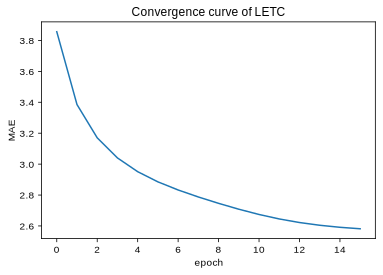

In [8]:
beta = 1e-3
rr = 0.1
rc = 1e-2 

start = time.time()
tensor_hat,_,_,_ = LETC(dense_tensor,sparse_tensor,Lc2=Lc2,Lr2=Lr2,rc=rc,rr=rr,beta=beta,transform='gft',is_rsvd=True,maxiter=30,incre=0.5,show_plot = True)
end  = time.time()
print('Running CPU time: %.1f seconds'%(end - start))

# License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>